In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
# functions needed for pr_auc_score()
from sklearn.metrics import auc, precision_recall_curve
from sklearn import metrics

# functions needed for imbalanced_cross_validation_score()
from sklearn.model_selection import StratifiedKFold

# sampler objects
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

# Classification models to compare
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.svm import SVC # SVM
from imblearn.ensemble import BalancedBaggingClassifier

from sklearn.metrics import matthews_corrcoef

from sklearn import preprocessing 

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def pr_auc_score(clf, x, y):

    precisions, recalls,_ = precision_recall_curve(y, clf.predict_proba(x)[:,1], pos_label=1)
    
    return auc(recalls, precisions)

In [3]:
def Confusion_matrix(clf, x, y):
    cm = metrics.confusion_matrix(y, clf.predict(x))
    mcc = matthews_corrcoef(y, clf.predict(x))
    
    return (cm[0][0], cm[0][1], cm[1][0], cm[1][1], mcc)

In [4]:
def imbalanced_cross_validation_score(clf, x, y, cv, scoring, sampler):
    
    cv_score = 0.
    train_score = 0.
    test_score = 0.
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    MCC = 0
    
    # stratified k-fold creates folds with the same ratio of positive 
    # and negative samples as the entire dataset.
    
    skf = StratifiedKFold(n_splits=cv, random_state=0, shuffle=False)
    
    for train_idx, test_idx in skf.split(x,y):
        
        xfold_train_sampled, yfold_train_sampled = sampler.fit_sample(x[train_idx],y[train_idx])
        clf.fit(xfold_train_sampled, yfold_train_sampled)
        
        TN_train, FP_train, FN_train, TP_train, mcc_train = scoring(clf, xfold_train_sampled, yfold_train_sampled)
        TN_test, FP_test, FN_test, TP_test, mcc_test  = scoring(clf, x[test_idx], y[test_idx])
        # tn, fp, fn, tp
        print("Train TP: {0} Train FP: {1} Train FN: {2} Train TN: {3}; Test TP: {4} Test FP: {5} Test FN: {6} Test TN: {7}".format(TP_train, FP_train, FN_train, TN_train, TP_test, FP_test, FN_test, TN_test))
        print("MCC train: {0} and MCC test: {1}".format(mcc_train, mcc_test))
        
        TP += TP_test
        FP += FP_test
        FN += FN_test
        TN += TN_test
        MCC += mcc_test

    ave_tp = TP/cv
    ave_fp = FP/cv
    ave_fn = FN/cv
    ave_tn = TN/cv
    ave_mcc = MCC/cv
    
    sensitivity = ave_tp/(ave_tp + ave_fn)
    specificity = ave_tn/(ave_fp + ave_tn)
    
    g_mean = math.sqrt(sensitivity * specificity)
    
    values = [sensitivity, specificity, g_mean, ave_mcc]
    
        
    return values

In [5]:
x_train_o = pd.read_csv('financial_data.csv')
y_train_o = pd.read_csv('revealed_businesses.csv')

x_test_o = pd.read_csv("testing_data.csv")

x_test_business_id = x_test_o['Var1']

x_train_o.replace('?', np.nan, inplace=True)
x_train_o = x_train_o.astype('float64')


x_test_o.replace('?', np.nan, inplace=True)
x_test_o = x_test_o.astype('float64')

data_all = x_train_o.merge(y_train_o, on='Var1', how = 'left')
data_all_id = data_all['Var1']

In [6]:
data_all_y = data_all.Var66
#use train_x all mean
data_train_all_mean = data_all.drop(columns=['Var1', 'Var66']).mean()
# only with label mean
# data_withLabel = data_all[data_all.Var66.notnull()]
# data_withLabel_mean = data_withLabel.drop(columns=['Var66']).mean()
x_train_imp_mean = data_all.drop(columns=['Var1', 'Var66']).fillna(data_train_all_mean)

In [7]:
# x_train_MinMax_fit = preprocessing.MinMaxScaler().fit(x_train_imp_mean)
# x_train_MinMax = x_train_MinMax_fit.transform(x_train_imp_mean)

# imp mean from train to x_test
x_test_imp_mean = x_test_o.drop(columns=['Var1']).fillna(data_train_all_mean)
# x_test_f = x_train_MinMax_fit.transform(x_test_imp_mean)

# x_MinMax_df = pd.DataFrame(data=x_train_MinMax, columns=x_train_imp_mean.columns)
# df_combine = pd.concat([data_all_id, x_MinMax_df, data_all_y], axis=1)

# for xgb

df_combine = pd.concat([data_all_id, x_train_imp_mean, data_all_y], axis=1)

In [8]:
data_nolabel = df_combine[df_combine.Var66.isnull()]
data_label = df_combine[df_combine.Var66.notnull()]

data_nolabel_v = data_nolabel.drop(columns=['Var1', 'Var66'])
data_nolabel_id = data_nolabel['Var1']

data_label_v = data_label.drop(columns=['Var1', 'Var66'])
data_label_id = data_label['Var1']

In [9]:
x = data_label_v.values
y = data_label['Var66'].values

In [10]:
data_label_v.shape

(4879, 64)

In [11]:
# feature selection
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor

# skb = SelectKBest(chi2, k=10)
# skb.fit_transform(x, y)


rf = RandomForestRegressor(random_state=77)
rf.fit(x, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=77, verbose=0, warm_start=False)

In [12]:
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), data_label_v.columns), 
             reverse=True))

[(0.2572, 'Var35'), (0.0791, 'Var28'), (0.0491, 'Var34'), (0.0351, 'Var59'), (0.0268, 'Var22'), (0.0258, 'Var47'), (0.0237, 'Var26'), (0.0218, 'Var42'), (0.0215, 'Var41'), (0.0213, 'Var62'), (0.0189, 'Var58'), (0.0181, 'Var65'), (0.0181, 'Var33'), (0.018, 'Var25'), (0.0178, 'Var7'), (0.016, 'Var16'), (0.0147, 'Var6'), (0.0144, 'Var43'), (0.0139, 'Var45'), (0.0135, 'Var36'), (0.013, 'Var48'), (0.0126, 'Var10'), (0.0125, 'Var50'), (0.0112, 'Var21'), (0.0109, 'Var30'), (0.0102, 'Var17'), (0.0094, 'Var56'), (0.0093, 'Var60'), (0.0092, 'Var5'), (0.0089, 'Var55'), (0.0087, 'Var37'), (0.0085, 'Var27'), (0.0082, 'Var38'), (0.0076, 'Var46'), (0.0075, 'Var57'), (0.0075, 'Var40'), (0.0074, 'Var3'), (0.0068, 'Var61'), (0.0067, 'Var63'), (0.0065, 'Var13'), (0.0064, 'Var29'), (0.0063, 'Var64'), (0.0056, 'Var51'), (0.0054, 'Var31'), (0.0052, 'Var14'), (0.005, 'Var39'), (0.0049, 'Var15'), (0.0048, 'Var23'), (0.0046, 'Var4'), (0.0044, 'Var54'), (0.0044, 'Var20'), (0.0042, 'Var18'), (0.0041, 'Var32'), (

In [13]:
ranking = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), data_label_v.columns), 
             reverse=True)
topFeaturesRF = []
    

In [14]:
for index, item in enumerate(ranking):
    topFeaturesRF.append(item[1])
    if index == 15:
        break

In [15]:
topFeaturesRF

['Var35',
 'Var28',
 'Var34',
 'Var59',
 'Var22',
 'Var47',
 'Var26',
 'Var42',
 'Var41',
 'Var62',
 'Var58',
 'Var65',
 'Var33',
 'Var25',
 'Var7',
 'Var16']

In [16]:
newX_RF = data_label_v[topFeaturesRF]
newx_RF = newX_RF.values

In [17]:
# cols = skb.get_support(indices=True)
# features_chi2 = data_label_v.columns[cols]

In [18]:
# features_chi2

In [19]:
# newx_chi2 = data_label_v[features_chi2].values

In [21]:
# x_test_f_df = pd.DataFrame(data = x_test_f, columns=x_test_imp_mean.columns)
# x_test_f_fs = x_test_f_df[topFeaturesRF].values

In [22]:
x_random_Over_sampled, y_random_Over_sampled = RandomOverSampler(random_state=42).fit_sample(x,y)

In [24]:
from imblearn.over_sampling import BorderlineSMOTE, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalanceCascade, EasyEnsembleClassifier, RUSBoostClassifier

RANDOM_STATE=42

clfs={
    #'gnb': GaussianNB(),
    #'svm': SVC(),
    #'lr':  LogisticRegression(),
    #'rfc': RandomForestClassifier(random_state=RANDOM_STATE),
    #'et': ExtraTreesClassifier(),
    #'ada': AdaBoostClassifier(),
    #'ml': MLPClassifier(),
    'bb': BalancedBaggingClassifier(base_estimator = RandomForestClassifier(random_state=RANDOM_STATE), 
                                          random_state=RANDOM_STATE),
    'xgb': XGBClassifier(max_depth=5, subsample=0.8, scale_pos_weight=0.5),
    'rf_bb' : BalancedRandomForestClassifier(random_state = RANDOM_STATE),
#     'eec' : EasyEnsembleClassifier(random_state=RANDOM_STATE),
#     'rusb' : RUSBoostClassifier(random_state=0)
    
    
}
cv = 5

for clf_name in clfs:
    print("Classifier: {0}".format(clf_name))
    
    # Random Over-sampling
    print("Random over-sampling")
    values = imbalanced_cross_validation_score(clfs[clf_name], x, y, cv, Confusion_matrix, RandomOverSampler(random_state=RANDOM_STATE))
    print("sensitivity: %.2f | specificity: %.2f | g_mean: %.2f | ave_mcc: %.3f"%(values[0], values[1], values[2], values[3]))

#     #  SMOTE
#     print("SMOTE over-sampling")
#     values = imbalanced_cross_validation_score(clfs[clf_name], x, y, cv, Confusion_matrix, SMOTE(random_state=RANDOM_STATE))
#     print("sensitivity: %.2f | specificity: %.2f | g_mean: %.2f | ave_mcc: %.3f"%(values[0], values[1], values[2], values[3]))

#     # BorderlineSMOTE
#     print("BorderlineSMOTE")
#     values = imbalanced_cross_validation_score(clfs[clf_name], x, y, cv, Confusion_matrix, BorderlineSMOTE(random_state=RANDOM_STATE))
#     print("sensitivity: %.2f | specificity: %.2f | g_mean: %.2f | ave_mcc: %.3f"%(values[0], values[1], values[2], values[3]))

#     # SVMSMOTE
#     print("SVMSMOTE")
#     values = imbalanced_cross_validation_score(clfs[clf_name], x, y, cv, Confusion_matrix, SVMSMOTE(random_state=RANDOM_STATE))
#     print("sensitivity: %.2f | specificity: %.2f | g_mean: %.2f | ave_mcc: %.3f"%(values[0], values[1], values[2], values[3]))

#     #  ADASYN
#     print("ADASYN over-sampling")
#     values = imbalanced_cross_validation_score(clfs[clf_name], x, y, cv, Confusion_matrix, ADASYN(random_state=RANDOM_STATE))
#     print("sensitivity: %.2f | specificity: %.2f | g_mean: %.2f | ave_mcc: %.3f"%(values[0], values[1], values[2], values[3]))

#     #  SMOTEENN
#     print("SMOTEENN")
#     values = imbalanced_cross_validation_score(clfs[clf_name], x, y, cv, Confusion_matrix, SMOTEENN(random_state=RANDOM_STATE))
#     print("sensitivity: %.2f | specificity: %.2f | g_mean: %.2f | mcc: %.3f"%(values[0], values[1], values[2], values[3]))

#     #  SMOTETomek
#     print("SMOTETomek")
#     values = imbalanced_cross_validation_score(clfs[clf_name], x, y, cv, Confusion_matrix, SMOTETomek(random_state=RANDOM_STATE))
#     print("sensitivity: %.2f | specificity: %.2f | g_mean: %.2f | ave_mcc: %.3f"%(values[0], values[1], values[2], values[3]))

    print("-"*70)
    print()
    

Classifier: bb
Random over-sampling
Train TP: 3767 Train FP: 1 Train FN: 0 Train TN: 3766; Test TP: 9 Test FP: 1 Test FN: 25 Test TN: 941
MCC train: 0.9997345719926701 and MCC test: 0.4800591496516168
Train TP: 3767 Train FP: 1 Train FN: 0 Train TN: 3766; Test TP: 9 Test FP: 3 Test FN: 25 Test TN: 939
MCC train: 0.9997345719926701 and MCC test: 0.4351536380874149
Train TP: 3767 Train FP: 1 Train FN: 0 Train TN: 3766; Test TP: 12 Test FP: 1 Test FN: 22 Test TN: 941
MCC train: 0.9997345719926701 and MCC test: 0.5628260450447655
Train TP: 3767 Train FP: 2 Train FN: 0 Train TN: 3765; Test TP: 12 Test FP: 0 Test FN: 22 Test TN: 942
MCC train: 0.9994692143999724 and MCC test: 0.5872703826337319
Train TP: 3768 Train FP: 1 Train FN: 0 Train TN: 3767; Test TP: 10 Test FP: 0 Test FN: 24 Test TN: 941
MCC train: 0.9997346424260035 and MCC test: 0.5355397315075359
sensitivity: 0.31 | specificity: 1.00 | g_mean: 0.55 | ave_mcc: 0.520
------------------------------------------------------------------

In [25]:
from sklearn.metrics import matthews_corrcoef
def matthewscorrcoef3(estimator, X_test, y_test):
   return matthews_corrcoef(y_test, estimator.predict(X_test))

In [26]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV

rfc_params = {"criterion" : ["gini", "entropy"], "n_estimators" : [5, 10, 15, 20, 25, 30, 35, 40, 50]}

rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search1 = GridSearchCV(estimator = rf, param_grid = rfc_params, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring = matthewscorrcoef3)


In [27]:
grid_search1.fit(x_random_Over_sampled, y_random_Over_sampled)
grid_search1.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   14.7s finished


{'criterion': 'gini', 'n_estimators': 50}

In [28]:
bb_params = {'max_samples' : [0.5, 1.0],
             "n_estimators" : [30, 40, 50, 60]}

bb = BalancedBaggingClassifier(base_estimator = RandomForestClassifier())
                                          #n_estimators = 15, bootstrap = True)
# Instantiate the grid search model
grid_search2 = GridSearchCV(estimator = bb, param_grid = bb_params, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring = matthewscorrcoef3)

In [29]:
grid_search2.fit(x_random_Over_sampled, y_random_Over_sampled)
grid_search2.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.0min finished


{'max_samples': 1.0, 'n_estimators': 40}

In [30]:
# rf_bb tunning parameters
rf_bb_clf_params = {'criterion' : ['gini', 'entropy'],
             "n_estimators" : [50, 100, 150, 200, 250, 300],
                   'max_features': ['sqrt', 'log2']}

rf_bb_clf = BalancedRandomForestClassifier(random_state = RANDOM_STATE)

# Instantiate the grid search model
grid_search3 = GridSearchCV(estimator = rf_bb_clf, param_grid = rf_bb_clf_params, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring = matthewscorrcoef3)

In [31]:
grid_search3.fit(x_random_Over_sampled, y_random_Over_sampled)
grid_search3.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.7min finished


{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 50}

In [32]:
# xgb tunning parameters
 xgb_params = {'max_depth' : [3, 4, 5, 6, 7],
#              "n_estimators" : [100, 500, 100],
#                 'subsample': [0.8, 0.9, 1],
              'learning_rate': [0.2， 0.15， 0.1],
#               'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
#               'gamma': [0,1,5]
             }


xgb_clf = XGBClassifier(random_state = RANDOM_STATE)
# Instantiate the grid search model
grid_search4 = GridSearchCV(estimator = xgb_clf, param_grid = xgb_params, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring = matthewscorrcoef3)

In [33]:
grid_search4.fit(x_random_Over_sampled, y_random_Over_sampled)
grid_search4.best_params_

Fitting 5 folds for each of 2025 candidates, totalling 10125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 45.5min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 58.3min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 74.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 92.9min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 113.5min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 137.2min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 164.3min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 194.9min
[Parallel(n_jobs=-1)]: Done 9097 tasks     

{'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 500,
 'subsample': 0.8}

In [34]:
xgb_clf.get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample'])

0.9968195446053636

[0.99843383 0.99843383]
[[1911    6]
 [   0 1851]]
mcc: 0.9968195446053636


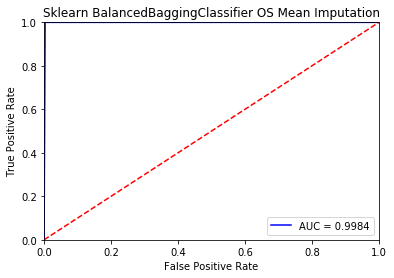

In [35]:
# best_period = os_dfs_dict['mean'][0]
# X = best_period.iloc[:,0:-1].values
# y = best_period["Var66"].values
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, matthews_corrcoef, confusion_matrix
from imblearn.metrics import geometric_mean_score

X_train, X_test, y_train, y_test = train_test_split(x_random_Over_sampled, y_random_Over_sampled, test_size=0.4, random_state= 42)

# BalancedBaggingClassifier
bb_classifier_roc = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion='gini', 
                                                          n_estimators = 50,
                                                          max_features = "sqrt"), 
                                          n_estimators = 40, bootstrap = True, random_state=42)
bb_classifier_roc.fit(X_train, y_train)
y_pred_dt = bb_classifier_roc.predict(X_test)


# rf_bb_clf_roc = rf_bb_classifier = BalancedRandomForestClassifier(n_estimators=300, criterion='entropy', max_features='sqrt', random_state = RANDOM_STATE)

# rf_bb_clf_roc.fit(X_train, y_train)
# y_pred_dt = rf_bb_clf_roc.predict(X_test)




fpr, tpr, threshold = roc_curve(y_test, y_pred_dt)
print(matthews_corrcoef(y_test, y_pred_dt))
print()

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_dt, labels=[0,1]).ravel()

print(geometric_mean_score(y_test, y_pred_dt, average=None))

print(confusion_matrix(y_test, y_pred_dt))
print("mcc: " + str((tp*tn-fp*fn)/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))))

roc_auc = auc(fpr, tpr)

plt.title('Sklearn BalancedBaggingClassifier OS Mean Imputation')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# 0.9962904829182986


In [42]:
bb_classifier = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion='gini', 
                                                          n_estimators = 50,
                                                          max_features = "sqrt"), 
                                          n_estimators = 40, bootstrap = True, random_state=42)

bb_classifier.fit(x_random_Over_sampled, y_random_Over_sampled)
y_pred_dt = bb_classifier.predict(x_test_imp_mean)


In [39]:
rf_bb_classifier = BalancedRandomForestClassifier(n_estimators=300, criterion='entropy', max_features='sqrt', random_state = RANDOM_STATE)

rf_bb_classifier.fit(x_random_Over_sampled, y_random_Over_sampled)
y_pred_dt = rf_bb_classifier.predict(x_test_imp_mean)


In [43]:
result = pd.DataFrame(y_pred_dt, columns=["Is_Bankrupted"])
upload = pd.concat([x_test_business_id, result], axis=1)
result["Is_Bankrupted"].value_counts()

0.0    1469
1.0      31
Name: Is_Bankrupted, dtype: int64

In [44]:
upload = upload.astype('int32')
upload.columns=['Business_ID', 'Is_Bankrupted']
upload.to_csv('3_30_5_57_bb.csv', index=False)